<a href="https://colab.research.google.com/github/yyeung-lam/MNE_CNN/blob/master/EEG_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models, Sequential
from tensorflow.keras.constraints import max_norm
from keras import backend as K
import matplotlib.pyplot as plt
!pip install mne==0.20.0
# CONNECT TO GOOGLE DRIVE: Note you need to have EEG folder into MyDrive
from google.colab import drive
drive.mount('/content/gdrive')

Using TensorFlow backend.


     |████████████████████████████████| 6.6MB 32.8MB/s 
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import mne
import numpy as np
import scipy, time
import scipy.io
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import sys

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import mne
from mne.datasets import sample
from mne.decoding import (SlidingEstimator, GeneralizingEstimator,
                          cross_val_multiscore, LinearModel, get_coef)


In [0]:
tmp_rootdir = '/content/gdrive/My Drive/EEG/'

#path to resampled data
resampled_dir = tmp_rootdir + 'resampled_data/'

# path to new data
new_dir = tmp_rootdir + 'New_Epoched_data/'

#path to store classifcation scores
# classify_dir = tmp_rootdir + "MNE/classification_logi_3electro/"
# fig_dir = classify_dir + "Figures/"

In [0]:
Mastoids = ['M1','M2']
EOG_list = ['HEOG', 'VEOG']
n_eeg_channels = 32

subj_list = ['001','002','003','004','005','006','007','008','009','010',
             '011','015','016',
             '021','022','024','025','027','029','030',
             '031','032','033']
#subj_list = ['001','002','003','004','005','008','009','011']

n_subj = len(subj_list) 
eeg_chan = []
eeg_chan = eeg_chan + ['A' + str(i+1) for i in range(32)]
chnames = eeg_chan + ['EXG' + str(i+1) for i in range(5)]
blocks = ['can', 'rev']
stimuli = ['standard', 'deviant']

biosemi_layout = mne.channels.read_custom_montage(tmp_rootdir + 'biosemi_cap_32_M_2_EOG_3.locs')
biosemi_layout.ch_names = chnames
event_id = {'standard/can':65321,
            'deviant/can':65322,
            'standard/rev':65341,
            'deviant/rev':65342,
            'can/beer':65391,
            'can/pier':65392,
            'can/Test1':65401,
            'can/Test2':65402,
            'rev/beer':65491,
            'rev/pier':65492,
            'rev/Test1':65501,
            'rev/Test2':65502
            }

In [0]:
##read the events from the event files instead of the stim channels in the data.
n_subj = len(subj_list)

In [0]:
# Normalize values to be between 0 and 1

In [0]:
# Convert 2D data to 3D for CNN model to run.
#X=X.reshape(len(X),1,len(X[0]),len(X[0][0]))
#X=np.swapaxes(X,1,2)

In [0]:
#out_size = np.random.choice(np.arange(Y.size),Y.size,replace=False)
#X=X[out_size,:,:]
#Y=Y[out_size]

In [0]:
# Ignore: This model is bad.
# model = models.Sequential()
# model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 91, 1)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))


# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(1,activation="sigmoid"))

In [0]:
# model.summary()

In [0]:
# out_size = np.random.choice(np.arange(Y.size),Y.size,replace=False)
# X_train=X[out_size[:int(Y.size*4/5)],:,:,:]
# Y_train=Y[out_size[:int(Y.size*4/5)]]

# X_test=X[out_size[int(Y.size*4/5):],:,:,:]
# Y_test=Y[out_size[int(Y.size*4/5):]]

# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# subj1_full = model.fit(X_train, Y_train, epochs=50,
#                   validation_data=(X_test, Y_test), batch_size=64)

[Deep learning with cnn for EEG](https://arxiv.org/pdf/1703.05051.pdf
)

In [0]:
#model.summary()

In [0]:
# Y_pred = np.zeros(len(Y))
# i = 0
# for y_hat,_ in model.predict(X):
#     if y_hat >= 0.5:
#         Y_pred[i] = 0
#     else:
#         Y_pred[i] = 1
#     i += 1

# from sklearn.metrics import classification_report
# print(classification_report(Y, Y_pred, target_names=['beer', 'pier']))

In [0]:
# out_size = np.random.choice(np.arange(Y.size),Y.size,replace=False)
# X_train=X[out_size[:int(Y.size*4/5)],:,:,:]
# Y_train=Y[out_size[:int(Y.size*4/5)]]

# X_test=X[out_size[int(Y.size*4/5):],:,:,:]
# Y_test=Y[out_size[int(Y.size*4/5):]]

# subj1 = model.fit(X_train, Y_train, epochs=50,
#                   validation_data=(X_test, Y_test))

In [0]:
# # Rev Model
# beer = epochs['revTest1'].crop(-0.2, 0.5)
# pier = epochs['revTest2'].crop(-0.2, 0.5)
# beer_raw = beer.get_data()[:, np.arange(32), :]
# pier_raw = pier.get_data()[:, np.arange(32), :]
# X = np.concatenate((beer_raw, pier_raw))
# Y = np.repeat([0,1], [np.shape(beer_raw)[0], np.shape(pier_raw)[0]], axis = 0)

In [0]:
# X = X.reshape(780,1,32,91)

# out_size = np.random.choice(np.arange(Y.size),Y.size,replace=False)
# X_train=X[out_size[:int(Y.size*4/5)],:,:,:]
# Y_train=Y[out_size[:int(Y.size*4/5)]]

# X_test=X[out_size[int(Y.size*4/5):],:,:,:]
# Y_test=Y[out_size[int(Y.size*4/5):]]

# subj1_rev = model.fit(X_train, Y_train, epochs=50,
#                   validation_data=(X_test, Y_test))

In [0]:
def get_dat(i):
  subj = subj_list[i]

  fname = resampled_dir+ "%s_resampled_raw.fif" %(subj)
  raw = mne.io.read_raw_fif(resampled_fname, preload = True)
  events = mne.find_events(raw)
  raw.set_eeg_reference('average', projection = True)
  baseline = (-0.2, 0.0)
  epochs = mne.Epochs(raw, events = events, event_id=event_id, 
                      tmin = -0.2, tmax = 0.5, baseline=baseline, preload= True)
  return epochs

In [0]:
#FZ = epochs.ch_names.index(epochs.ch_names[0:32])
def can_dat(epochs):
  numEpochs = len(epochs.ch_names)
  beer = epochs['Can/Test1'].crop(-0.2, 0.5)
  pier = epochs['Can/Test2'].crop(-0.2, 0.5)
  beer_raw = beer.get_data()[:, np.arange(numEpochs), :]
  pier_raw = pier.get_data()[:, np.arange(numEpochs), :]
  X = np.concatenate((beer_raw, pier_raw))
  Y = np.repeat([0,1], [np.shape(beer_raw)[0], np.shape(pier_raw)[0]], axis = 0)
  X=X.reshape(len(X),1,len(X[0]),len(X[0][0]))
  return X,Y

def rev_dat(epochs):
  numEpochs = len(epochs.ch_names)
  beer = epochs['Rev/Test1'].crop(-0.2, 0.5)
  pier = epochs['Rev/Test2'].crop(-0.2, 0.5)
  beer_raw = beer.get_data()[:, np.arange(numEpochs), :]
  pier_raw = pier.get_data()[:, np.arange(numEpochs), :]
  X = np.concatenate((beer_raw, pier_raw))
  Y = np.repeat([0,1], [np.shape(beer_raw)[0], np.shape(pier_raw)[0]], axis = 0)
  X=X.reshape(len(X),1,len(X[0]),len(X[0][0]))
  return X,Y

In [42]:
# sample model

# "channels_first" assumes (channels, rows, cols)
K.set_image_data_format('channels_first')
conv_filters = (1, 15)
strides = (1, 2)
pool_size = (1, 35)
dropoutRate = 0.5
model = models.Sequential()

model.add(layers.Conv2D(25, (1, 15), input_shape=(1, 32, 91),
                        kernel_constraint = max_norm(2., axis=(0,1,2))))
model.add(layers.Conv2D(25, (32, 1), use_bias=False,
                        kernel_constraint = max_norm(2., axis=(0,1,2))))
model.add(layers.BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1))
model.add(layers.Activation('elu'))
model.add(layers.MaxPooling2D(pool_size=(1,2), strides=strides))
model.add(layers.Dropout(dropoutRate))

model.add(layers.Conv2D(50, (1, 5), use_bias=False,
                        kernel_constraint = max_norm(2., axis=(0,1,2))))
model.add(layers.BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1))
model.add(layers.Activation('elu'))
model.add(layers.MaxPooling2D(pool_size=(1,2), strides=strides))
model.add(layers.Dropout(dropoutRate))

model.add(layers.Conv2D(100, (1, 5), use_bias=False,
                        kernel_constraint = max_norm(2., axis=(0,1,2))))
model.add(layers.BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1))
model.add(layers.Activation('elu'))
model.add(layers.MaxPooling2D(pool_size=(1,2), strides=strides))
model.add(layers.Dropout(dropoutRate))

model.add(layers.Flatten())
model.add(layers.Dense(2))
model.add(layers.Activation('softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_124"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_259 (Conv2D)          (None, 25, 32, 77)        400       
_________________________________________________________________
conv2d_260 (Conv2D)          (None, 25, 1, 77)         20000     
_________________________________________________________________
batch_normalization_133 (Bat (None, 25, 1, 77)         100       
_________________________________________________________________
activation_249 (Activation)  (None, 25, 1, 77)         0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 25, 1, 38)         0         
_________________________________________________________________
dropout_127 (Dropout)        (None, 25, 1, 38)         0         
_________________________________________________________________
conv2d_261 (Conv2D)          (None, 50, 1, 34)      

In [0]:
# shallow CNN
def run_model(numChan):
  conv_filters = (1, 15)
  strides = (1, 3)
  pool_size = (1, 5)
  dropoutRate = 0.5
  model = models.Sequential()

  model.add(layers.Conv2D(25, (1, 15), input_shape=(1, numChan, 91),
                          kernel_constraint = max_norm(2., axis=(0,1,2))))
  model.add(layers.Conv2D(25, (numChan, 1), use_bias=False,
                          kernel_constraint = max_norm(2., axis=(0,1,2))))
  model.add(layers.BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1))
  model.add(layers.Activation('elu'))
  model.add(layers.MaxPooling2D(pool_size=(1,2), strides=strides))
  model.add(layers.Dropout(dropoutRate))

  model.add(layers.Conv2D(50, (1, 5), use_bias=False,
                          kernel_constraint = max_norm(2., axis=(0,1,2))))
  model.add(layers.BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1))
  model.add(layers.Activation('elu'))
  model.add(layers.MaxPooling2D(pool_size=(1,2), strides=strides))
  model.add(layers.Dropout(dropoutRate))

  # model.add(layers.Conv2D(100, (1, 5), use_bias=False,
  #                         kernel_constraint = max_norm(2., axis=(0,1,2))))
  # model.add(layers.BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1))
  # model.add(layers.Activation('elu'))
  # model.add(layers.MaxPooling2D(pool_size=(1,2), strides=strides))
  # model.add(layers.Dropout(dropoutRate))

  model.add(layers.Flatten())
  model.add(layers.Dense(2))
  model.add(layers.Activation('softmax'))

  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [0]:
%%capture
# Train and tune on canoncal data 
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)
epochs = 100

train_loss_can = np.zeros((len(subj_list), epochs))
train_accuracy_can = np.zeros((len(subj_list), epochs))
valid_loss_can = np.zeros((len(subj_list), epochs))
valid_accuracy_can = np.zeros((len(subj_list), epochs))
CV = np.zeros((len(subj_list), 5))

for i in range(len(subj_list)):
  #epoch1 = get_dat(i)
  epoch1 = mne.read_epochs(new_dir + '/%s_epoch_M.fif' %subj_list[i])
  canX, canY = can_dat(epoch1)
  model = run_model(len(epoch1.ch_names))

  # K-Fold Cross-Validation
  k = 0
  for train_index, test_index in kf.split(canX):
    X_train, X_test = canX[train_index], canX[test_index]
    y_train, y_test = canY[train_index], canY[test_index]

    CV_history = model.fit(X_train, y_train, epochs=epochs, 
                              validation_data=(X_test, y_test))
    
    CV[i][k] = CV_history.history['val_accuracy'][-1]
    k += 1
  
  train_loss_can[i] = CV_history.history['loss']
  train_accuracy_can[i] = CV_history.history['accuracy']
  valid_loss_can[i] = CV_history.history['val_loss']
  valid_accuracy_can[i] = CV_history.history['val_accuracy']

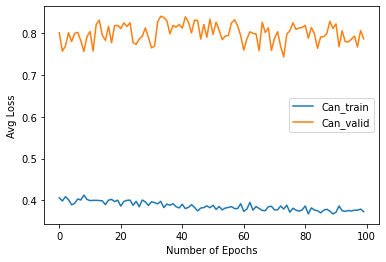

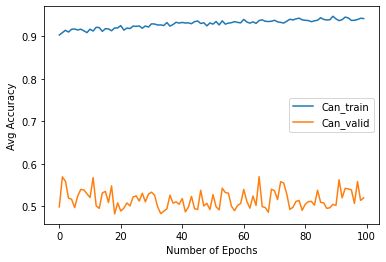

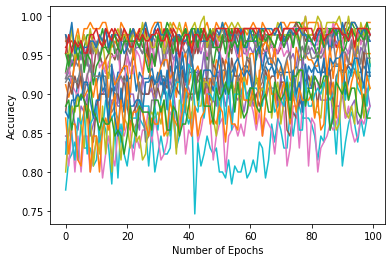

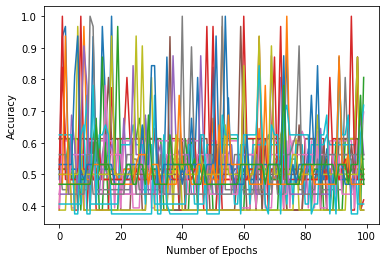

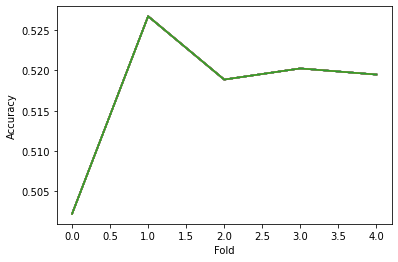

In [102]:
plt.plot(np.arange(epochs), np.mean(train_loss_can, axis=0))
plt.plot(np.arange(epochs), np.nanmean(valid_loss_can, axis=0))
plt.xlabel('Number of Epochs')
plt.ylabel('Avg Loss')
plt.legend(['Can_train', 'Can_valid'])
plt.show()

plt.plot(np.arange(epochs), np.mean(train_accuracy_can, axis=0))
plt.plot(np.arange(epochs), np.mean(valid_accuracy_can, axis=0))
plt.xlabel('Number of Epochs')
plt.ylabel('Avg Accuracy')
plt.legend(['Can_train', 'Can_valid'])
plt.show()

for i in range(len(subj_list)):
  plt.plot(np.arange(epochs), train_accuracy_can[i])
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
#plt.legend(subj_list)
plt.show()

for i in range(len(subj_list)):
  plt.plot(np.arange(epochs), valid_accuracy_can[i])
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
#plt.legend(subj_list)
plt.show()

for i in range(len(subj_list)):
  plt.plot(np.arange(5), np.mean(CV, axis=0))
plt.xlabel('Fold')
plt.ylabel('Accuracy')
#plt.legend(subj_list)
plt.show()

In [0]:
%%capture
train_loss_rev = np.zeros((len(subj_list), epochs))
train_accuracy_rev = np.zeros((len(subj_list), epochs))
valid_loss_rev = np.zeros((len(subj_list), epochs))
valid_accuracy_rev = np.zeros((len(subj_list), epochs))


for i in range(len(subj_list)):
  epoch1 = mne.read_epochs(new_dir + '/%s_epoch_M.fif' %subj_list[i])
  revX, revY = rev_dat(epoch1)
  out_size = np.random.choice(np.arange(revY.size),revY.size,replace=False)
  X_train=revX[out_size[:int(revY.size*4/5)],:,:,:]
  Y_train=revY[out_size[:int(revY.size*4/5)]]

  X_test=revX[out_size[int(revY.size*4/5):],:,:,:]
  Y_test=revY[out_size[int(revY.size*4/5):]]

  model = run_model(len(epoch1.ch_names))

  history_train = model.fit(X_train, Y_train, epochs=epochs,
                          validation_data=(X_test, Y_test))

  train_loss_rev[i] = history_train.history['loss']
  train_accuracy_rev[i] = history_train.history['accuracy']
  valid_loss_rev[i] = history_train.history['val_loss']
  valid_accuracy_rev[i] = history_train.history['val_accuracy']

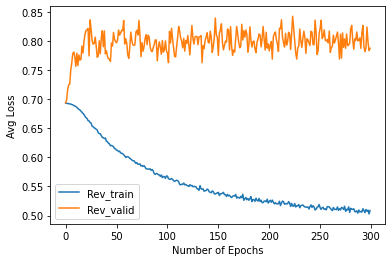

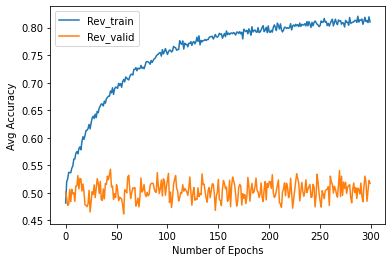

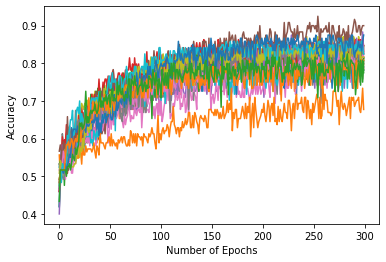

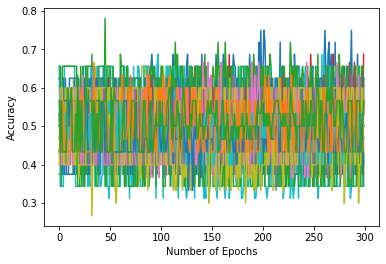

In [19]:
plt.plot(np.arange(epochs), np.mean(train_loss_rev, axis=0))
plt.plot(np.arange(epochs), np.nanmean(valid_loss_rev, axis=0))
plt.xlabel('Number of Epochs')
plt.ylabel('Avg Loss')
plt.legend(['Rev_train', 'Rev_valid'])
plt.show()

plt.plot(np.arange(epochs), np.mean(train_accuracy_rev, axis=0))
plt.plot(np.arange(epochs), np.mean(valid_accuracy_rev, axis=0))
plt.xlabel('Number of Epochs')
plt.ylabel('Avg Accuracy')
plt.legend(['Rev_train', 'Rev_valid'])
plt.show()

for i in range(len(subj_list)):
  plt.plot(np.arange(epochs), train_accuracy_rev[i])
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
#plt.legend(subj_list)
plt.show()

for i in range(len(subj_list)):
  plt.plot(np.arange(epochs), valid_accuracy_rev[i])
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
#plt.legend(subj_list)
plt.show()

In [0]:
def can_run(X,Y):
  out_size = np.random.choice(np.arange(Y.size),Y.size,replace=False)
  X_train=X[out_size[:int(Y.size*4/5)],:,:,:]
  Y_train=Y[out_size[:int(Y.size*4/5)]]

  X_test=X[out_size[int(Y.size*4/5):],:,:,:]
  Y_test=Y[out_size[int(Y.size*4/5):]]

  history_can = model.fit(X_train, Y_train, epochs=epochs,
                          validation_data=(X_test, Y_test))

  argss = np.argmax(history_can.history['val_loss'])
  return history_can.history['accuracy'][argss], history_can.history['val_accuracy'][argss], history_can.history['accuracy'][epochs-1], history_can.history['val_accuracy'][epochs-1]
  
def rev_run(X,Y):
  # Rev Model
  out_size = np.random.choice(np.arange(Y.size),Y.size,replace=False)
  X_train=X[out_size[:int(Y.size*4/5)],:,:,:]
  Y_train=Y[out_size[:int(Y.size*4/5)]]

  X_test=X[out_size[int(Y.size*4/5):],:,:,:]
  Y_test=Y[out_size[int(Y.size*4/5):]]

  history_rev = model.fit(X_train, Y_train, epochs=epochs,
                          validation_data=(X_test, Y_test))
  
  argss = np.argmax(history_rev.history['val_loss'])
  return history_rev.history['accuracy'][argss], history_rev.history['val_accuracy'][argss], history_rev.history['accuracy'][epochs-1], history_rev.history['val_accuracy'][epochs-1]

In [0]:
can_train = [0]*len(subj_list)
can_val = [0]*len(subj_list)
rev_train = [0]*len(subj_list)
rev_val = [0]*len(subj_list)

can_train50 = [0]*len(subj_list)
can_val50 = [0]*len(subj_list)
rev_train50 = [0]*len(subj_list)
rev_val50 = [0]*len(subj_list)

In [0]:
%%capture
# Train and validate on rev data using the same architecture
for i in range(len(subj_list)):
  epoch1 = get_dat(i)
  canX, canY = can_dat(epoch1)
  revX, revY = rev_dat(epoch1)

  can_train1, can_val1, can_train150, can_val150 = can_run(canX,canY)
  rev_train1, rev_val1, rev_train150, rev_val150 = rev_run(revX,revY)

  can_train[i] = can_train1
  can_val[i] = can_val1
  rev_train[i] = rev_train1
  rev_val[i] = rev_val1

  can_train50[i] = can_train150
  can_val50[i] = can_val150
  rev_train50[i] = rev_train150
  rev_val50[i] = rev_val150

In [0]:
%%capture
plt.boxplot([can_train,can_val,rev_train,rev_val], labels = ['Can_Train','Can_Val','Rev_Train','Rev_Val'])

In [0]:
%%capture
plt.boxplot([can_train50,can_val50,rev_train50,rev_val50], labels = ['Can_Train','Can_Val','Rev_Train','Rev_Val'])